In [ ]:
!pip install torch torchvision transformers datasets facenet-pytorch albumentations evaluate -q

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import (
    AutoImageProcessor,
    BeitForImageClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset, Dataset as HFDataset, DatasetDict
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
from tqdm import tqdm
import evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
!unzip /content/cv_dataset.zip -d /content/dataset

Archive:  /content/cv_dataset.zip
   creating: /content/dataset/cv_dataset/
   creating: /content/dataset/cv_dataset/train/
   creating: /content/dataset/cv_dataset/train/bored/
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_1.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_10.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_2.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_3.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_4.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_5.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_6.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_7.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_8.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Advait_Bored_9.jpg  
  inflating: /content/dataset/cv_dataset/train/bored/Bored (1).jpg  
  inflating:

In [ ]:

drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive/EmotionCheckpoints"
os.makedirs(save_dir, exist_ok=True)

dataset_root = "/content/dataset/cv_dataset"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

labels = sorted(os.listdir(os.path.join(dataset_root, "train")))
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}
print("Labels:", label2id)

Mounted at /content/drive
Using device: cuda
Labels: {'bored': 0, 'confused': 1, 'engaged': 2, 'neutral': 3}


In [ ]:
import random
processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

class EmotionDataset(Dataset):
    def __init__(self, root_dir, processor, label2id, transform=None, target_samples_per_class=None):
        self.processor = processor
        self.label2id = label2id
        self.samples = []
        self.transform = transform
        self.target_samples_per_class = target_samples_per_class
        self.class_counts = {}

        all_samples = []
        for label_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label_name)
            class_samples = []
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                    class_samples.append((os.path.join(class_dir, img_file), label_name))
            self.class_counts[label_name] = len(class_samples)
            all_samples.extend(class_samples)

        if target_samples_per_class:
            # Perform oversampling
            for label_name, count in self.class_counts.items():
                current_label_samples = [s for s in all_samples if s[1] == label_name]
                if count < target_samples_per_class:
                    samples_to_add = target_samples_per_class - count
                    # Use random.choices for sampling with replacement
                    oversampled_samples = random.choices(
                        current_label_samples,
                        k=samples_to_add
                    )
                    self.samples.extend(oversampled_samples)
                self.samples.extend(current_label_samples[:target_samples_per_class])
        else:
            self.samples = all_samples


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_name = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze()
        label = self.label2id[label_name]

        return {"pixel_values": pixel_values, "labels": torch.tensor(label)}

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

target_samples = 150

train_dataset = EmotionDataset(os.path.join(dataset_root, "train"), processor, label2id, transform=train_transform, target_samples_per_class=target_samples)
val_dataset = EmotionDataset(os.path.join(dataset_root, "val"), processor, label2id, transform=val_transform) # Apply consistent transformations to validation set

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

Train samples: 600 | Val samples: 76


In [ ]:
# --- LOAD MODEL ---
model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224-pt22k-ft22k",
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_metric.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=p.label_ids, average="weighted")["f1"]
    return {"accuracy": acc, "f1": f1}

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- TRAINING ARGUMENTS ---
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=7,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    push_to_hub=False,
)
class DriveSaverTrainer(Trainer):
    def _save_checkpoint(self, model, trial, metrics=None):
        super()._save_checkpoint(model, trial)
        latest_ckpt = os.path.join(self.args.output_dir, f"checkpoint-{self.state.global_step}")
        if os.path.exists(latest_ckpt):
            dest = os.path.join(save_dir, f"checkpoint-{self.state.global_step}")
            !cp -r "{latest_ckpt}" "{dest}"
            print(f"✅ Saved checkpoint to Drive: {dest}")

trainer = DriveSaverTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    processing_class=processor,
)

In [ ]:
# --- TRAIN ---
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.333600,0.972848,0.710526,0.707131
2,0.699100,0.686482,0.828947,0.823856
3,0.448900,0.582498,0.750000,0.744486
4,0.221200,0.461137,0.855263,0.857331
5,0.148400,0.390329,0.855263,0.854638
6,0.078800,0.457722,0.828947,0.827913
7,0.062200,0.408300,0.868421,0.868383


✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-75
✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-150
✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-225
✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-300
✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-375
✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-450
✅ Saved checkpoint to Drive: /content/drive/MyDrive/EmotionCheckpoints/checkpoint-525


TrainOutput(global_step=525, training_loss=0.4158090832119896, metrics={'train_runtime': 521.7694, 'train_samples_per_second': 8.05, 'train_steps_per_second': 1.006, 'total_flos': 3.25333082382336e+17, 'train_loss': 0.4158090832119896, 'epoch': 7.0})

In [ ]:

trainer.save_model(os.path.join(save_dir, "final_model_4"))
print(f" Final model saved to {save_dir}/final_model_4")

✅ Final model saved to /content/drive/MyDrive/EmotionCheckpoints/final_model_4


In [ ]:
import cv2
import torch
from transformers import BeitForImageClassification, AutoImageProcessor
from PIL import Image
import numpy as np




In [ ]:
# --- Load model from Drive ---
model_path = "/content/drive/MyDrive/EmotionCheckpoints/final_model"
model = BeitForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          

In [ ]:
# --- Define labels ---
labels = list(model.config.id2label.values())
device = "cuda" if torch.cuda.is_available() else "cpu"



🧠 Detected Emotion: neutral


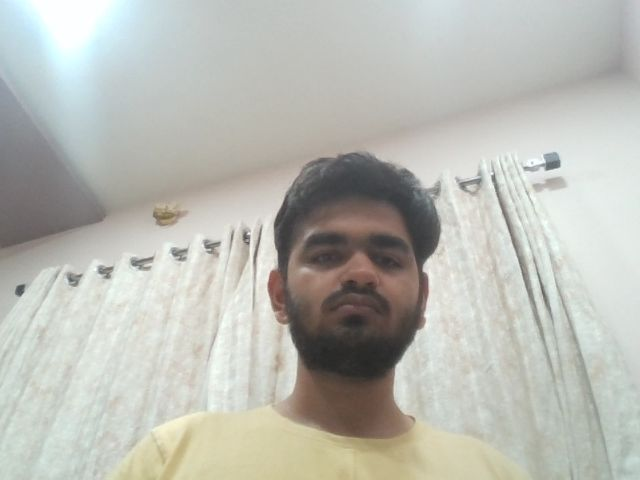

In [ ]:

from transformers import BeitForImageClassification, AutoImageProcessor
import torch
from PIL import Image

# Load model and processor
model_path = "/content/drive/MyDrive/EmotionCheckpoints/final_model"
model = BeitForImageClassification.from_pretrained(model_path)
processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

labels = list(model.config.id2label.values())

# Run inference
img = Image.open("photo.jpg").convert("RGB")
inputs = processor(images=img, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**inputs).logits
    pred_id = torch.argmax(logits, dim=-1).item()
    pred_label = labels[pred_id]

# Show result
print(f"🧠 Detected Emotion: {pred_label}")
display(img)
